In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.stats as st

## "All of Statistics: A Concise Course in Statistical Inference" 

### Chapter 8: The Bootstrap

**Problem 1** Consider the data in Example 8.6. Find the plug-in estimate of the correlation coefficient. Estimate the standard error using the bootstrap. Find a 95 percent confidence interval using the Normal, pivotal, and percentile methods.

In [2]:
#Data from Exampe 8.6 (Last 2.96 is 3.96 in the book but that is a typo!)

LSAT = np.array([576, 635, 558, 578, 666, 580, 555, 661, 651, 605, 653, 575, 545, 572, 594])
GPA = np.array([3.39, 3.30, 2.81, 3.03, 3.44, 3.07, 3.00, 3.43, 3.36, 3.13, 3.12, 2.74, 2.76, 2.88, 2.96])

LSAT, GPA

(array([576, 635, 558, 578, 666, 580, 555, 661, 651, 605, 653, 575, 545,
        572, 594]),
 array([3.39, 3.3 , 2.81, 3.03, 3.44, 3.07, 3.  , 3.43, 3.36, 3.13, 3.12,
        2.74, 2.76, 2.88, 2.96]))

I took two approaches. First with a straightforward loop, which was the first that came to mind. Then I realized that it would be much faster to do it with matrix operations and modified the functions, adding a '\_vec' suffix.

In [3]:
def correlation(x, y):
    '''takes two ndarrays which contain corresponding values of a size 2 sample and returns their correlation'''
    cov = np.dot(x - x.mean(), y - y.mean())
    varx = np.dot(x - x.mean(), x - x.mean())
    vary = np.dot(y - y.mean(), y - y.mean())
    return cov / np.sqrt(varx * vary)

correlation(LSAT, GPA)

0.7763744912894068

In [4]:
def correlation_vec(x, y):
    '''takes two ndarrays which contain corresponding values of a size 2 sample and returns their correlation'''
    cov = np.sum((x - x.mean(axis=1,keepdims=True))*(y - y.mean(axis=1,keepdims=True)), axis = 1)
    varx = np.sum((x - x.mean(axis=1,keepdims=True))*(x - x.mean(axis=1,keepdims=True)), axis = 1)
    vary = np.sum((y - y.mean(axis=1,keepdims=True))*(y - y.mean(axis=1,keepdims=True)), axis = 1)
    return np.divide(cov, np.sqrt(varx * vary))

correlation_vec(np.expand_dims(LSAT, 0), np.expand_dims(GPA, 0))

array([0.77637449])

In [5]:
testx = np.array([[1,2,3],[1,2,3],[1,2,3]]).reshape(3,3)
testy = np.array([[3,2,1],[1,-1,1],[1,4,6]]).reshape(3,3)
display(correlation_vec(testx, testy))

array([-1.        ,  0.        ,  0.99339927])

In [6]:
def bootstrap(x, y, B):
    correlations = []
    for _ in range(B):
        reindex = np.random.choice(np.arange(x.size), x.size)
        sample_x = x[reindex]
        sample_y = y[reindex]
        correlations.append(correlation(sample_x, sample_y))
    return correlations

bootstrap(LSAT, GPA, 10)

[0.8402526156216097,
 0.7600920891183592,
 0.7050336312723589,
 0.866532758432249,
 0.6145234493907283,
 0.679952252221017,
 0.9052023179992592,
 0.9197705952981864,
 0.6967142140954236,
 0.8782773441402966]

In [7]:
def bootstrap_vec(x, y, B):
    reindex = np.random.choice(np.arange(x.size), x.size * B)
    samples_x = x[reindex].reshape(B, x.size)
    samples_y = y[reindex].reshape(B, y.size)
    return correlation_vec(samples_x, samples_y)

bootstrap_vec(LSAT, GPA, 10)

array([0.84569452, 0.89638557, 0.89318532, 0.6595843 , 0.78725568,
       0.92046049, 0.64392635, 0.85736036, 0.39081917, 0.80999995])

We see that both the loop based approach and the vectorized approach give the same results but the vectorized approach is much faster! About 10 times faster for smaller $B$ (around $10,000$ or less) and 100 times faster for $B=100,000$.

In [8]:
B = 100_000

In [9]:
%%time
print('B = ', B, 'estimated se = ', np.sqrt(np.square(np.array(bootstrap(LSAT, GPA, B)) - correlation(LSAT, GPA)).mean()))

B =  100000 estimated se =  0.13418651499876919
CPU times: user 8.58 s, sys: 141 ms, total: 8.72 s
Wall time: 10.1 s


In [10]:
%%time
print('B = ', B, 'estimated se = ', np.sqrt(np.square(bootstrap_vec(LSAT, GPA, B) - correlation(LSAT, GPA)).mean()))

B =  100000 estimated se =  0.133447203154569
CPU times: user 74.3 ms, sys: 26.3 ms, total: 101 ms
Wall time: 103 ms


Now onto the confidence intervals! We need to find a 95 percent confidence interval using the Normal, pivotal, and percentile methods.

In [11]:
# Normal Interval

point_estimate = correlation(LSAT, GPA)
B = 10_000
se_est = np.sqrt(np.square(bootstrap_vec(LSAT, GPA, B) - correlation(LSAT, GPA)).mean())
z = st.norm.ppf(0.975)

point_estimate - se_est * z , point_estimate + se_est * z

(0.5154023020460072, 1.0373466805328064)

In [12]:
# Pivotal Interval, aka empirical confidence interval or just the "regular" bootstrap confidence interval

# Get 0.025 and 0.975 quantiles q025 and q975 of the distribution of bootstrap replications

point_estimate = correlation(LSAT, GPA)
B = 10_000
replications = bootstrap_vec(LSAT, GPA, B)

q025 = np.sort(replications)[math.floor(0.025*B)+1]
q975 = np.sort(replications)[math.floor(0.975*B)+1]

2*point_estimate - q975, 2*point_estimate - q025

(0.5919423424539318, 1.0971018741991798)

In [13]:
# Percentile interval
# This one also uses the quantiles, but differently from the pivotal one

B = 10_000
replications = bootstrap_vec(LSAT, GPA, B)

q025 = np.sort(replications)[math.floor(0.025*B)]
# q025 = np.quantile(replications, 0.025)
q975 = np.sort(replications)[math.floor(0.975*B)]
# q975 = np.quantile(replications, 0.975)

q025, q975

(0.4626903885655937, 0.9632396840161818)

**Notes:**
 - The correlation can also be computed with the following libraries. However, I check below that my implementation is actually a little faster.
     - numpy `corrcoef` (call on pair of arrays) (returns *correlation matrix*)
     - scipy.stats `pearsonr` (call on pair of arrays) (returns *tuple* (p-value, correlation))
     - pandas `df1.corr(df2)`(call on one dataframe with the other one as the first argument) (default is pearson but method can also be se to other correlation measures such as 'spearman' and 'kendall')
 - Quantiles can be computed with `np.quantile(a, q)`. That is much faster than my implementation (sorting the whole array is of course not the most optimal way of computing a quantile!), so I will use it from now on.

In [14]:
%timeit correlation(LSAT, GPA)

51.8 µs ± 2.69 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [15]:
%timeit np.corrcoef(LSAT, GPA)

74 µs ± 2.11 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [16]:
%timeit q025 = np.sort(replications)[math.floor(0.025*B)]

536 µs ± 6.51 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [17]:
%timeit q025 = np.quantile(replications, 0.025)

159 µs ± 6.96 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


**Problem 2** Conduct a simulation to compare the various boootstrap confidence interval methods. Let $n=50$ and let $T(F) = \int(x-\mu)^3\text{d}F(x)/\sigma^3$ be the skewness. Draw $Y_1,\dots,Y_n\sim N(0,1)$ and set $X_i = e^{Y_i}$, $i=1,\dots,n$. Construct the three types of bootstrap 95 percent intervals for $T(F)$ from the data $X_1,\dots,X_n$. Repeat this whole thing many times and estimate the true coverage of the three intervals.

First I will write a function to check the coverage, and three functions to create the three types of confidence intervals.

In [18]:
def coverage(intervals, true_value):
    '''Takes list of intervals (tuples of endpoints) and the true value.
    Outputs the fraction of the intervals that contain the true value.'''
    count = 0
    for interval in intervals:
        if interval[0] < true_value < interval[1]:
            count += 1
    return count / len(intervals)

In [19]:
def normal_interval(point_estimate, replications, alpha):
    '''Takes in a point estimate, an array of bootstrap replications of this estimate and a number alpha.
    Outputs the endpoints of the 1 - alpha normal confidence interval'''
    z = st.norm.ppf(1 - alpha/2)
    est_se = np.sqrt(np.square(replications - point_estimate).mean())
    return point_estimate - z * est_se, point_estimate + z * est_se

normal_interval(correlation(LSAT, GPA), bootstrap_vec(LSAT, GPA, 10_000), 0.05) # Check agreeement with code in previous exercise

(0.5138781390921126, 1.0388708434867011)

In [20]:
def pivotal_interval(point_estimate, replications, alpha):
    '''Takes in a point estimate, an array of bootstrap replications of this estimate and a number alpha.
    Outputs the endpoints of the 1 - alpha pivotal confidence interval'''
    qleft = np.quantile(replications, alpha/2)
    qright = np.quantile(replications, 1 - alpha/2)
    return 2*point_estimate - qright, 2*point_estimate - qleft

pivotal_interval(correlation(LSAT, GPA), bootstrap_vec(LSAT, GPA, 10_000), 0.05) # Check agreeement with code in previous exercise

(0.5914088575235175, 1.0847050695097944)

In [21]:
def percentile_interval(replications, alpha):
    '''Takes an array of bootstrap replications of a point estimate (but not the estimate itself) and a number alpha.
    Outputs the endpoints of the 1 - alpha percentile confidence interval'''
    qleft = np.quantile(replications, alpha/2)
    qright = np.quantile(replications, 1 - alpha/2)
    return qleft, qright

percentile_interval(bootstrap_vec(LSAT, GPA, 10_000), 0.05) # Check agreeement with code in previous exercise

(0.4544561561183764, 0.9603581266067835)

Now I will write two functions to check the skewness (a non-vectorized one and a vectorized one) and a function that does the bootstrapping.

In [22]:
def skewness(x):
    xcenter = x - x.mean()
    third_moment = (np.power(xcenter, 3)).mean()
    sd = np.sqrt((np.square(xcenter)).mean())
    return third_moment / sd**3

In [23]:
def skewness_vec(x):
    '''Take in a 2D array and compute the skewness of its rows'''
    xcenter = x - x.mean(axis=1, keepdims=True)
    third_moment = np.mean(np.power(xcenter, 3), axis=1)
    sd = np.sqrt(np.square(xcenter).mean(axis=1))
    return third_moment / sd**3

In [24]:
def bootstrap(func, sample, B): # Make into a decorator?
    '''Take vectorized function, a random sample and a number B.
    Create a 2D array with B rows, each row being a bootstrap resampling
    from the passed sample, and apply the function to that 2D array'''
    n = sample.size
    reindex = np.random.choice(np.arange(n), n*B)
    resampling = sample[reindex].reshape(B, n)
    return func(resampling)

Now we can start drawing random samples from $N(0,1)$, find the different types of bootstrap intervals for each sample, and compute the coverage.

In [25]:
# I will start with a for loop for convenience but this could also be vectorized

true_value = (np.exp(1) + 2) * np.sqrt(np.exp(1) - 1) # skewness of log-normal distribution

normal_intervals = []
pivotal_intervals = []
percentile_intervals = []
alpha = 0.05
reps = 500
size = 50
B = 10_000

for _ in range(reps):
    norm_sample = st.norm.rvs(size=size)
    transf_sample = np.exp(norm_sample)
    point_estimate =  skewness(transf_sample)
    replications = bootstrap(skewness_vec, transf_sample, B)
    normal_intervals.append(normal_interval(point_estimate, replications, alpha))
    pivotal_intervals.append(pivotal_interval(point_estimate, replications, alpha))
    percentile_intervals.append(percentile_interval(replications, alpha))
    
(
    'normal int coverage',
    coverage(normal_intervals, true_value),
    'pivotal int coverage',
    coverage(pivotal_intervals, true_value),
    'percentile int coverage',
    coverage(percentile_intervals, true_value)
)

('normal int coverage',
 0.138,
 'pivotal int coverage',
 0.142,
 'percentile int coverage',
 0.02)

The "95% intervals" have a terrible coverage (under 2% for the percentile interval and under 15% for the others two), which might be because of the long tail of the log-normal distribution... I checked that the intervals have 95% coverage for the normal distribution.

**Problem 3** Let $X-1,\dots,X-n \sim t_3$ where $n=25$. Let $\theta = T(F) = (q_.75 - q_.25)/1.34$ where $q_p$ denotes the $p$<sup>th</sup> quantile. Do a simulation to compare the coverage and length of the three confidence intervals for $\theta$.

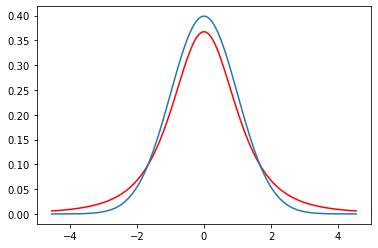

In [26]:
df = 3 # degrees of freedom

rv = st.t(df)

x = np.linspace(rv.ppf(.01), rv.ppf(.99), 100)
plt.plot(x, rv.pdf(x), color='red');
plt.plot(x, st.norm.pdf(x));

In [27]:
# Plug-in estimator for theta

def plugin_theta(a):
    if len(a.shape) == 1:
        return (np.quantile(a, .75) - np.quantile(a, .25)) / 1.34
    return (np.quantile(a, .75, axis=1) - np.quantile(a, .25, axis=1)) / 1.34

In [28]:
# I will start with a for loop for convenience but this could also be vectorized
df = 3
rv = st.t(df)

true_value = (rv.ppf(.75) - rv.ppf(.25)) / 1.34
normal_intervals = []
pivotal_intervals = []
percentile_intervals = []
alpha = 0.05
reps = 1000
size = 25
B = 10_000

for _ in range(reps):
    sample = rv.rvs(size=size)
    point_estimate =  plugin_theta(sample)
    replications = bootstrap(plugin_theta, sample, B)
    normal_intervals.append(normal_interval(point_estimate, replications, alpha))
    pivotal_intervals.append(pivotal_interval(point_estimate, replications, alpha))
    percentile_intervals.append(percentile_interval(replications, alpha))

print('true value = ', true_value)

print(
    'normal int coverage',
    coverage(normal_intervals, true_value),
    '\npivotal int coverage',
    coverage(pivotal_intervals, true_value),
    '\npercentile int coverage',
    coverage(percentile_intervals, true_value)
)

print(
    'avg normal int',
    (sum(list(zip(*normal_intervals))[0])/ len(normal_intervals), sum(list(zip(*normal_intervals))[1])/ len(normal_intervals)),
    '\navg pivotal int',
    (sum(list(zip(*pivotal_intervals))[0])/ len(normal_intervals), sum(list(zip(*pivotal_intervals))[1]) / len(pivotal_intervals)),
    '\navg percentile int',
    (sum(list(zip(*percentile_intervals))[0])/ len(normal_intervals), sum(list(zip(*percentile_intervals))[1]) / len(percentile_intervals))
)

true value =  1.1416303404192403
normal int coverage 0.962 
pivotal int coverage 0.836 
percentile int coverage 0.974
avg normal int (0.3766069954742327, 1.784367985992408) 
avg pivotal int (0.31540849719955477, 1.625609933413223) 
avg percentile int (0.5353650480534176, 1.845566484267086)


In the previous problem the worst interval by far was the percentile interval, although they all performed terribly. In this problem the worst is the pivotal interval, but  the difference as pronounced: The normal and percentile intervals are at slightly over 95% (as they should) and the pivotal interval is at 85%.

**Problem 6**  Let $X_1,\dots,X_n \sim N(\mu,1)$. Let $\theta = e^\mu$ and let $\hat\theta = e^{\bar X_n}$. Create a data set (using $\mu=5$) consisting of $n=100$ observations.
1. Use the bootstrap to get the $\mathrm{se}$ and 95 percent confidence intervals for $\theta$.
2. Plot a histogram of the bootstrap replications. This is an estimate of the distribution of $\hat\theta$. Compare this to the true sampling distribution of $\hat\theta$.

In [29]:
# I will start with a for loop for convenience but this could also be vectorized

rv = st.norm(loc=5)

def exp_mean(a):
    if len(a.shape)==1:
        return np.exp(a.mean())
    return np.exp(a.mean(axis=1))

true_value = np.exp(5)
normal_intervals = []
pivotal_intervals = []
percentile_intervals = []
alpha = 0.05
reps = 500
size = 100
B = 10_000

for _ in range(reps):
    sample = rv.rvs(size=size)
    point_estimate =  exp_mean(sample)
    replications = bootstrap(exp_mean, sample, B)
    normal_intervals.append(normal_interval(point_estimate, replications, alpha))
    pivotal_intervals.append(pivotal_interval(point_estimate, replications, alpha))
    percentile_intervals.append(percentile_interval(replications, alpha))

print('true value = ', true_value)

print(
    'normal int coverage',
    coverage(normal_intervals, true_value),
    '\npivotal int coverage',
    coverage(pivotal_intervals, true_value),
    '\npercentile int coverage',
    coverage(percentile_intervals, true_value)
)

print(
    'avg normal int',
    (sum(list(zip(*normal_intervals))[0])/ len(normal_intervals), sum(list(zip(*normal_intervals))[1])/ len(normal_intervals)),
    '\navg pivotal int',
    (sum(list(zip(*pivotal_intervals))[0])/ len(normal_intervals), sum(list(zip(*pivotal_intervals))[1]) / len(pivotal_intervals)),
    '\navg percentile int',
    (sum(list(zip(*percentile_intervals))[0])/ len(normal_intervals), sum(list(zip(*percentile_intervals))[1]) / len(percentile_intervals))
)

true value =  148.4131591025766
normal int coverage 0.942 
pivotal int coverage 0.94 
percentile int coverage 0.93
avg normal int (120.35803245594967, 179.35341640978396) 
avg pivotal int (117.56707629592611, 176.38247815079322) 
avg percentile int (123.32897071494064, 182.14437256980744)


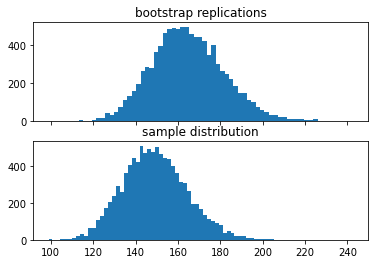

In [30]:
B=10_000
size=100
rv = st.norm(loc=5)

fig, (ax1, ax2) = plt.subplots(2, sharex=True)

sample = rv.rvs(size=size)
replications = bootstrap(exp_mean, sample, B)

ax1.hist(replications, bins='auto')
ax1.set_title('bootstrap replications')

sample_means = rv.rvs(size=size*B).reshape(B, size).mean(axis=1)
sample_exp_means = np.exp(sample_means)

ax2.hist(sample_exp_means, bins='auto')
ax2.set_title('sample distribution');

We see that the bootstrap histogram is biased, which makes sense because it is based entirely on a specific random sample realization that will be skewed in one direction or another in a random way: the mean of a specific realization of the random sample is precisely a realization of the sample mean, which follows the sampling distribution approximated in the bottom histogram. The standard deviation of the sampling distribution is the *standard error* of the sample mean as an estimate of the population mean, and this standard deviation is the one we can approximate pretty well using the bootstrap.

I experimented with it, and once one reaches samples of size $10,000$ the bias starts being unnoticeable by just lookign at the histograms. The exponential makes the bias more noticeable as well. Below I did the same analysis but omitting the exponential. Repeatedly generating new histograms makes it clear that the bootstrap histogram keeps jumping left and right around the true sample distribution.

However, it does seem to estimate the standard deviation pretty well, just from looking at the picture.

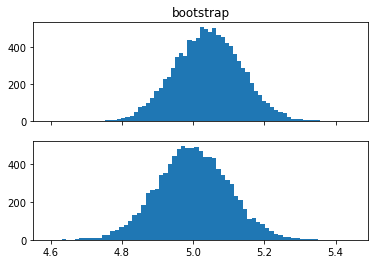

In [31]:
B=10_000
size=100
rv = st.norm(loc=5)

def regular_mean(a):
    if len(a.shape)==1:
        return a.mean()
    return a.mean(axis=1)

fig, (ax1, ax2) = plt.subplots(2, sharex=True)

sample = rv.rvs(size=size)
replications = bootstrap(regular_mean, sample, B)

ax1.hist(replications, bins='auto')
ax1.set_title('bootstrap')

sample_means = rv.rvs(size=size*B).reshape(B, size).mean(axis=1)

ax2.hist(sample_means, bins='auto');


**Problem 7**  Let $X_1,\dots,X_n \sim \text{Uniform}(0,\theta)$. Let $\hat\theta = X_{max} = \max\{X_1\dots,X_n\}$. Generate a data set of size 50 with $\theta=1$.
1. Find the distribution of $\hat\theta$. Compare the distribution of $\hat\theta$ to the histograms from the bootstrap.
2. This is a case where the bootstrap does very poorly. In fact, we can prove that this is the case. Show that $P(\hat\theta^* = \hat\theta) \approx .632$. Hint: show that $P(\hat\theta^* = \hat\theta) = 1 - (1 - (1/n))^n$, then take the limit as $n$ gets large.

Part 2 is not hard: $\hat\theta^* = \hat\theta$ is the case precisely when the largest $X_i$ is part of the bootstrap sample. The probability randomly choosing $n$ of the $X_i$ with replacement and not picking the maximum (or any specific $X_i$ for that matter) is $1 - (1 - (1/n))^n$.

Now onto part 1: The distribution of $\hat\theta = X_{max} = \max\{X_1\dots,X_n\}$ is $\text{Beta}(n-1,2)$ and has PDF $f(x) = nx^{n-1}$ and CDF $F(x) = x^n = \mathbb{P}(X_i \le x)^n$.

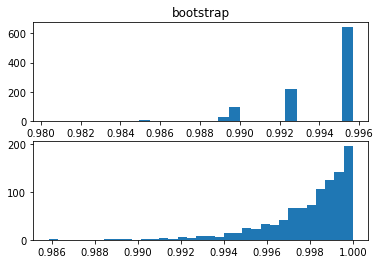

In [32]:
B=1000
size=500
rv = st.uniform()

def maximum(a):
    if len(a.shape)==1:
        return a.max()
    return a.max(axis=1)

fig, (ax1, ax2) = plt.subplots(2, sharex=False)

sample = rv.rvs(size=size)
replications = bootstrap(maximum, sample, B)

ax1.hist(replications, bins='auto')
ax1.set_title('bootstrap')

sample_means = rv.rvs(size=size*B).reshape(B, size).max(axis=1)

ax2.hist(sample_means, bins='auto');


Final notes for the Chapter 8 exercises:

- `scipy.stats` has the best bootstrap support among the general purpose stats packages (the `resample` package seems to have more features but it is specialized for resampling methods as the name indicates and it is pretty new and not well-known). It has a bootstrap function that computed confidence intervals using three methods: percentile, pivotal and BCa. It also returns the standard error, with which one could compute the normal interval.
- `statsmodels` doesn't seem to have a lot of support for bootstrapping.
- `sklearn` has support for the bootstrap within cross-validation
- There is a library called `resample`, which is mostly for bootstrapping and permutation tests. This one looks to be actively mantained as of 2021 and it has lots of features!
- There is another library called `bootstrapped`, but it doesn't look like it is being mantained since 2018 (I'm writing this on Oct 2021). It's bootstrap function also seems less powerful than the `scipy.stats` one. I assume this library was written at a time when the bootstrap support in `scipy` was lacking, and before `resample` existed, which seems to be superior.